In [1]:
import numpy as np
import multiprocessing as mp
from scipy.stats import norm, normaltest, ttest_1samp
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from simulate import simulate_job
from config_plt import config_plt, get_fig_ax, save_my_fig

In [2]:
mp.set_start_method("spawn", force=True)
T = 20_000
n_reps = 10_000
a_target = 100
n_jobs = 4
ss = np.random.SeedSequence(1)
child_ss = ss.spawn(n_reps)
seeds = [int(s.generate_state(1)[0]) for s in child_ss]
args = [(seed, T, a_target) for seed in seeds]
with mp.Pool(processes=n_jobs) as pool:
    results = list(tqdm(pool.imap_unordered(simulate_job, args, chunksize=1), total=n_reps))

100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:24<00:00, 41.54it/s]


In [3]:
psis = np.asarray([r["psi"] for r in results])
psis_naive = np.asarray([r["psi_naive"] for r in results])
tauhats = np.asarray([r["tauhat"] for r in results])
taus = np.asarray([r["tau"] for r in results])
equal_groups = np.asarray([r["equal_group"] for r in results])
t_targets = np.asarray([r["t_target"] for r in results])
us = tauhats - taus
zs = us / np.sqrt(psis / T)
zs_naive = us / np.sqrt(psis_naive / T)

In [4]:
psis_equal = psis[equal_groups]
psis_equal_mean = np.mean(psis_equal)
print(psis_equal_mean)
psis_naive_equal = psis_naive[equal_groups]
psis_naive_equal_mean = np.mean(psis_naive_equal)
print(psis_naive_equal_mean)

psis_unequal = psis[~equal_groups]
psis_unequal_mean = np.mean(psis_unequal)
print(psis_unequal_mean)
psis_naive_unequal = psis_naive[~equal_groups]
psis_naive_unequal_mean = np.mean(psis_naive_unequal)
print(psis_naive_unequal_mean)

153.68110348764188
109.7802126186108
242.02956370192803
166.01014668895718


TtestResult(statistic=np.float64(2.337043393594317), pvalue=np.float64(0.01963372640148202), df=np.int64(999))
TtestResult(statistic=np.float64(-0.8695661091885458), pvalue=np.float64(0.38474643969461664), df=np.int64(999))
NormaltestResult(statistic=np.float64(8.52251474521465), pvalue=np.float64(0.01410455657286391))
./figures/z


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


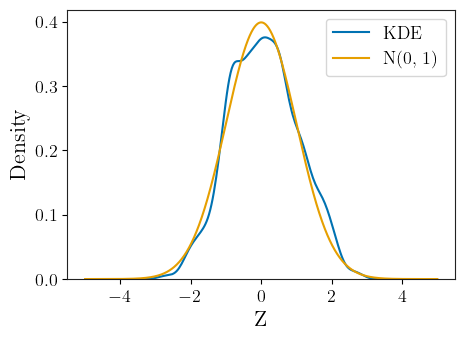

In [5]:
print(ttest_1samp(zs, popmean=0.))
print(ttest_1samp(zs**2, popmean=1.))
print(normaltest(zs))
fig, ax = get_fig_ax()
ax = sns.kdeplot(zs, ax=ax, bw_method=0.2, label="KDE")
zs_vals = np.linspace(-5, 5, 1000)
gaussian_pdf_vals = norm.pdf(zs_vals)
ax.plot(zs_vals, gaussian_pdf_vals, label="N(0, 1)")
ax.set_xlabel("Z")
ax.legend()
save_my_fig(fig, "z")

TtestResult(statistic=np.float64(2.313731165287339), pvalue=np.float64(0.020884690420968105), df=np.int64(999))
TtestResult(statistic=np.float64(5.472691671687936), pvalue=np.float64(5.604842238569578e-08), df=np.int64(999))
NormaltestResult(statistic=np.float64(4.986148851762621), pvalue=np.float64(0.082655457463286))
./figures/z-naive


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


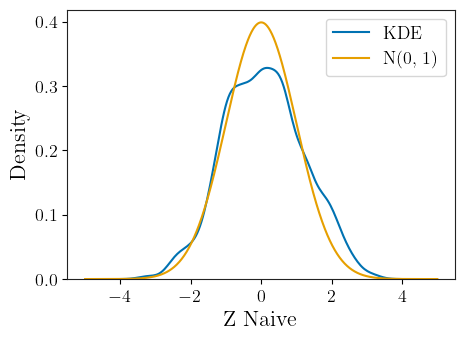

In [6]:
print(ttest_1samp(zs_naive, popmean=0.))
print(ttest_1samp(zs_naive**2, popmean=1.))
print(normaltest(zs_naive))
fig, ax = get_fig_ax()
ax = sns.kdeplot(zs_naive, ax=ax, bw_method=0.2, label="KDE")
ax.plot(zs_vals, gaussian_pdf_vals, label="N(0, 1)")
ax.set_xlabel("Z Naive")
ax.legend()
save_my_fig(fig, "z-naive")

TtestResult(statistic=np.float64(2.0239590614640934), pvalue=np.float64(0.043240122937217615), df=np.int64(999))
NormaltestResult(statistic=np.float64(4.566184692528074), pvalue=np.float64(0.10196839707906898))
./figures/u


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


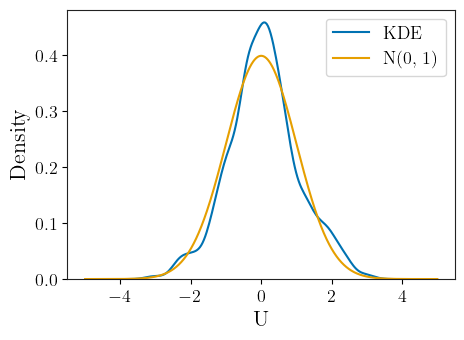

In [7]:
us_std = us / np.std(us)
print(ttest_1samp(us_std, popmean=0.))
# print(ttest_1samp(us_std**2, popmean=1.))
print(normaltest(us_std))
fig, ax = get_fig_ax()
ax = sns.kdeplot(us_std, bw_method=0.2, ax=ax, label="KDE")
ax.plot(zs_vals, gaussian_pdf_vals, label="N(0, 1)")
ax.set_xlabel("U")
ax.legend()
save_my_fig(fig, "u")

(array([  8.,  43., 132., 264., 219., 192.,  94.,  36.,  10.,   2.]),
 array([157. , 166.8, 176.6, 186.4, 196.2, 206. , 215.8, 225.6, 235.4,
        245.2, 255. ]),
 <BarContainer object of 10 artists>)

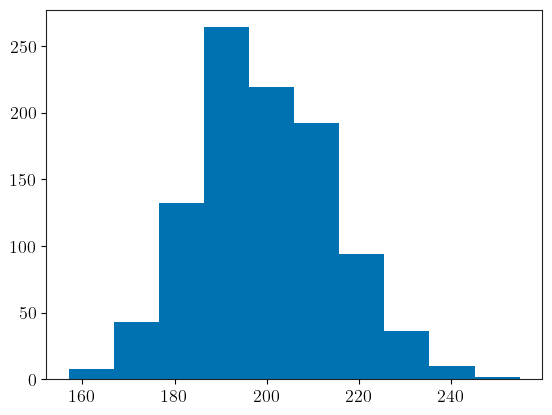

In [8]:
plt.hist(t_targets)

(array([  4.,  28.,  50., 142., 264., 264., 129.,  73.,  37.,   9.]),
 array([0.5771906 , 0.66171403, 0.74623747, 0.83076091, 0.91528435,
        0.99980779, 1.08433123, 1.16885466, 1.2533781 , 1.33790154,
        1.42242498]),
 <BarContainer object of 10 artists>)

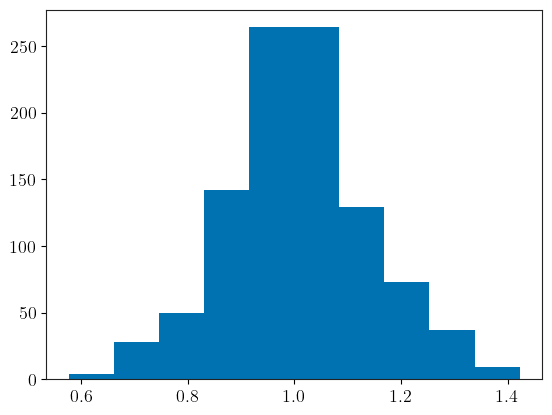

In [9]:
plt.hist(tauhats)

(array([  7.,  31.,  80., 140., 234., 232., 168.,  70.,  30.,   8.]),
 array([0.95029116, 0.96005859, 0.96982602, 0.97959345, 0.98936088,
        0.99912831, 1.00889573, 1.01866316, 1.02843059, 1.03819802,
        1.04796545]),
 <BarContainer object of 10 artists>)

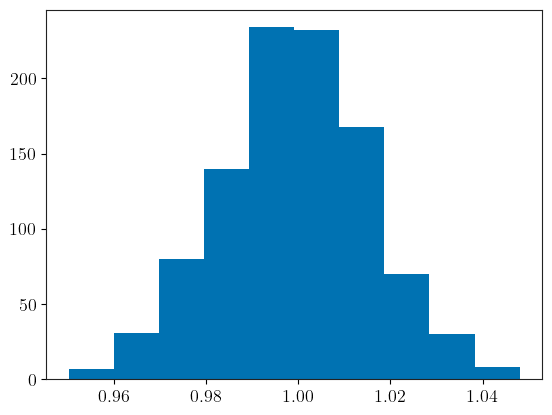

In [10]:
plt.hist(taus)